In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, softmax, sigmoid, swish
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50  import preprocess_input

2022-12-20 17:12:24.098255: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-12-20 17:12:35.924950: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-20 17:12:35.927970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-20 17:12:35.961296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 17:12:35.961616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.755GHz coreCount: 38 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-12-20 17:12:35.961682: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-20 17:12:35.968383: I tensorflow/stream_executor/platform

In [3]:
datagenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=30,
    vertical_flip=True,
    #brightness_range=[0.90,1.45],
    samplewise_center=True,
    samplewise_std_normalization=True
    #fill_mode='nearest'
)

In [9]:
# load and iterate training dataset
train_data = datagenerator.flow_from_directory('/local/data1/chash345/train', 
    class_mode='binary',
    target_size=(250, 250), 
    batch_size=32, 
    shuffle=False,
    color_mode='rgb'
)

# load and iterate validation dataset
val_data = datagenerator.flow_from_directory('/local/data1/chash345/valid', 
    class_mode='binary',
    target_size=(250, 250),
    batch_size=1, 
    shuffle=False,
    color_mode='rgb'
)

# load and iterate test dataset
test_data = datagenerator.flow_from_directory('/local/data1/chash345/test', 
    class_mode='binary',
    target_size=(250, 250),
    batch_size=1, 
    shuffle=False,
    color_mode='rgb'
)

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 250 pixels width and 250 pixels height, one single color channel.
The maximum pixel value is 8.3162 and the minimum is -4.3143
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


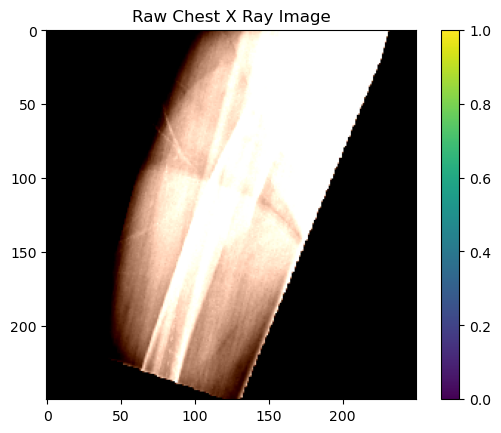

In [10]:
#sns.set_style('white')
generated_image, label = train_data.__getitem__(24)
plt.imshow(generated_image[7])

plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [11]:
generated_image.shape

(32, 250, 250, 3)

In [12]:
pre_trained_model = VGG16(input_shape=(250,250,3),
                                include_top=False,
                                weights="imagenet")

# Some weights in later layers are unfreezed
for layer in pre_trained_model.layers[:-5]:
    layer.trainable=False

tf.random.set_seed(200)

model = tf.keras.models.Sequential([
    pre_trained_model,
    Flatten(),    
    Dense(512,activation="swish"),
    Dropout(0.5),
    # Dense(256,activation="relu"),
    # Dropout(0.5),
    Dense(128, activation='relu'),  
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 27,626,049
Trainable params: 19,990,785
Non-trainable params: 7,635,264
__________________________________

In [14]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight= 'balanced', y =train_data.classes, classes=np.unique(train_data.classes))
dict_weights = {0: weights[0], 1:weights[1]}
dict_weights

{0: 2.5, 1: 0.625}

In [15]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data=val_data, 
    class_weight=dict_weights 
)

2022-12-20 17:13:43.272168: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-20 17:13:43.273009: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492035000 Hz


Epoch 1/5


2022-12-20 17:13:44.553266: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-20 17:13:51.763915: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-12-20 17:19:48.131052: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-12-20 17:19:48.280754: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-12-20 17:19:50.944641: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the av

82/82 [==============================] - 988s 7s/step - loss: 0.6300 - accuracy: 0.8275 - val_loss: 0.6927 - val_accuracy: 0.7989
Epoch 2/5
82/82 [==============================] - 564s 7s/step - loss: 0.6953 - accuracy: 0.7984 - val_loss: 0.6926 - val_accuracy: 0.7989
Epoch 3/5
 9/82 [==>...........................] - ETA: 4:30 - loss: 0.4572 - accuracy: 0.9811

In [ ]:
model = model.save('vgg16')

In [ ]:
model.evaluate(test_data)

14/14 [==============================] - 130s 9s/step - loss: 0.5075 - acc: 0.7998


[0.5075328946113586, 0.7997685074806213]